# Clasificación de Tweets de desastres naturales

## Enunciado

En esta competición, se plantea la construcción de un modelo de aprendizaje automático que realice predicciones sobre qué Tweets tratan de desastres reales y cuáles no.

https://www.kaggle.com/vstepanenko/disaster-tweets

# 0 - Exploración del Dataset

## 0. Imports

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Visualizadores
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os

# Utilidades
import sys
sys.path.append("..\..")
from package_utilities import clean_text_field

#Otros
import re # Expresiones regulares
import string

# Stopwords
import nltk
from nltk.corpus import stopwords

# Etiquetado POS
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter


## 1. Lectura del conjunto de datos

In [2]:
X_train = pd.read_csv('../../data/originals/train.csv')
X_test = pd.read_csv('../../data/originals/test.csv')

X_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


De las 5 categorías, en este caso, solo la categoría "text" es útil, que contiene los tuits, y la categoría "target" que indica 1 si se refiere a catástrofes o 0 en caso contrario.


In [3]:
X_train_disaster = X_train.query("target == 1").reset_index()
X_train_no_disaster = X_train.query("target == 0").reset_index()

In [4]:
print("1")
for i in range(5):
    print(X_train_disaster["text"][i])

print("0")
for i in range(5):
    print(X_train_no_disaster["text"][i])


1
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
0
What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


In [5]:
X_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## 2. Visualización del conjunto de datos

In [6]:
print("Tamaño del conjunto de datos de entrenamiento: ", len(X_train))
print("Tamaño del conjunto de datos de pruebas: ", len(X_test))

Tamaño del conjunto de datos de entrenamiento:  7613
Tamaño del conjunto de datos de pruebas:  3263


In [7]:
# Tweets de cada tipo que se encuentran en el conjunto de datos de entrenamiento
X_train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

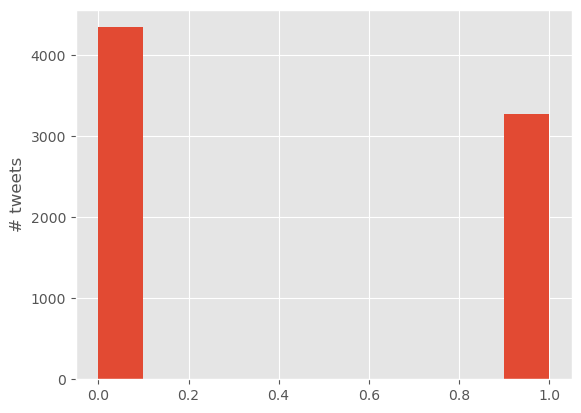

In [8]:
X_train['target'].hist()
plt.ylabel("# tweets")
plt.show()

Siempre conveniente realizar un análisis exploratorio de la distribución de los datos para determinar la mejor manera de resolver el problema

## 3 Analísis de la estructura del dataset

### Número de palabras por Tweet

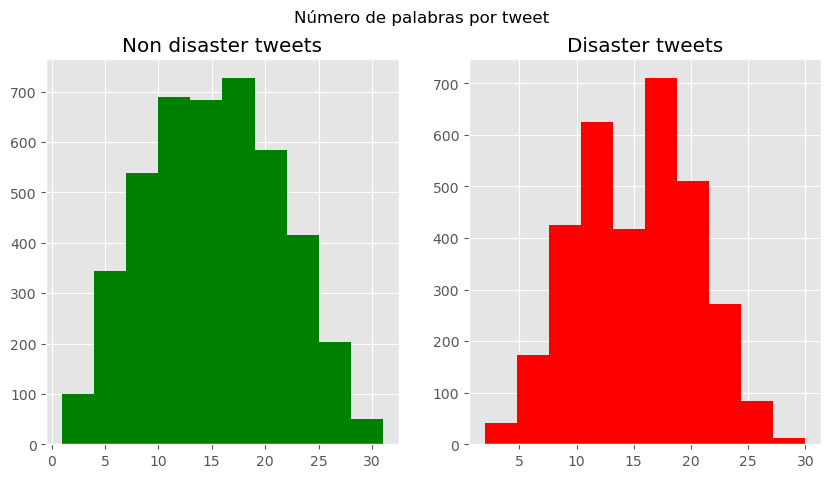

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de palabras
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.split().map(lambda x: len(x))
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.split().map(lambda x: len(x))

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de palabras por tweet')

plt.show()

### Número de palabras únicas por Tweet

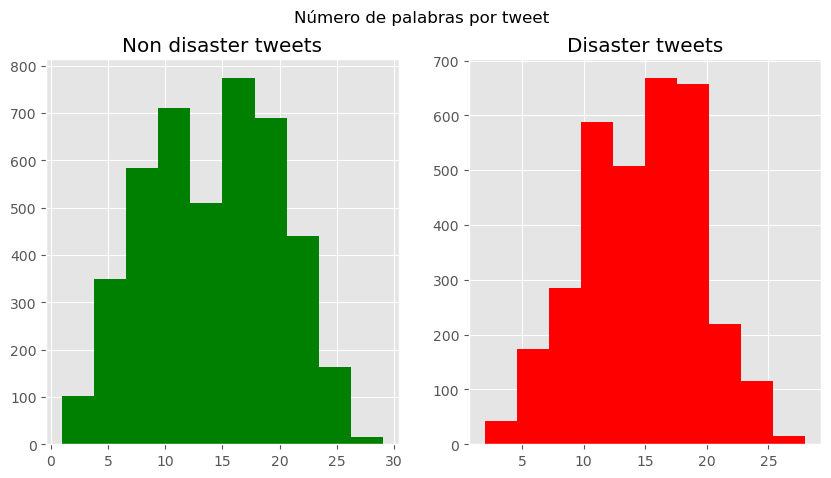

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de palabras
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.split().map(lambda x: len(set(x)))
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.split().map(lambda x: len(set(x)))

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de palabras por tweet')

plt.show()

### Longitud media de las palabras por Tweet

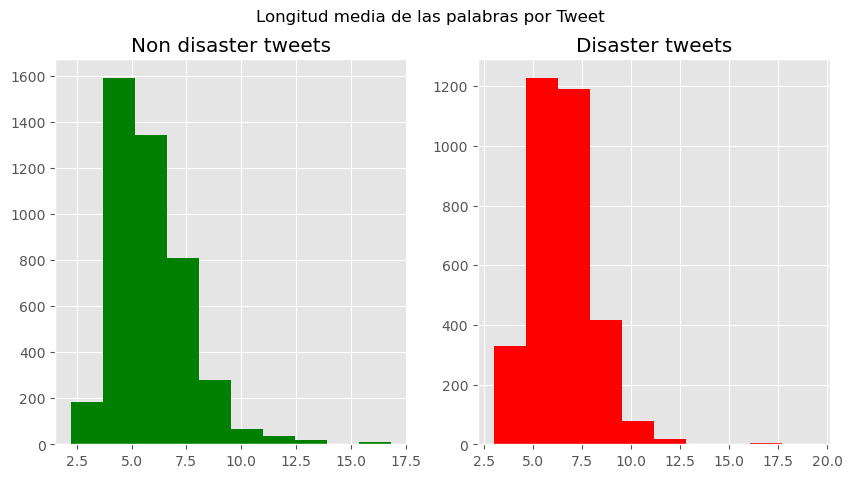

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de palabras
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.split().map(lambda x: np.mean([len(i) for i in x]))
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.split().map(lambda x: np.mean([len(i) for i in x]))

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Longitud media de las palabras por Tweet')

plt.show()

### Número de caracteres por Tweet

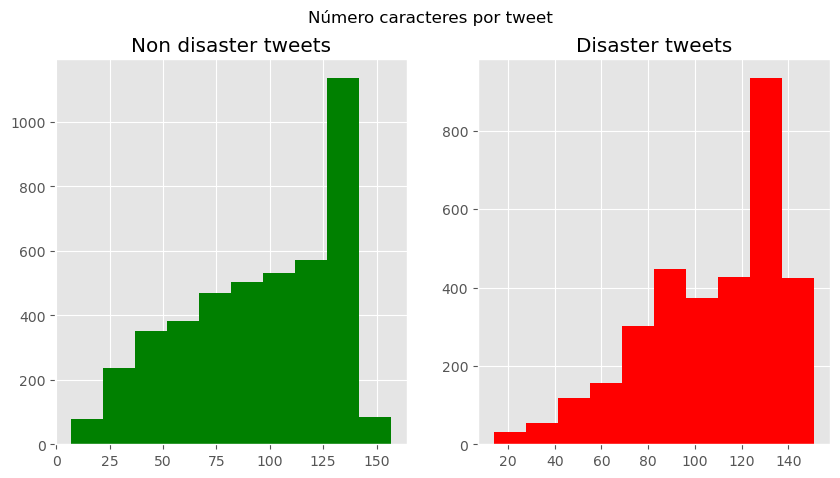

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de caracteres por tweet
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.len()
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.len()

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número caracteres por tweet')

plt.show()

### Número de urls por Tweet

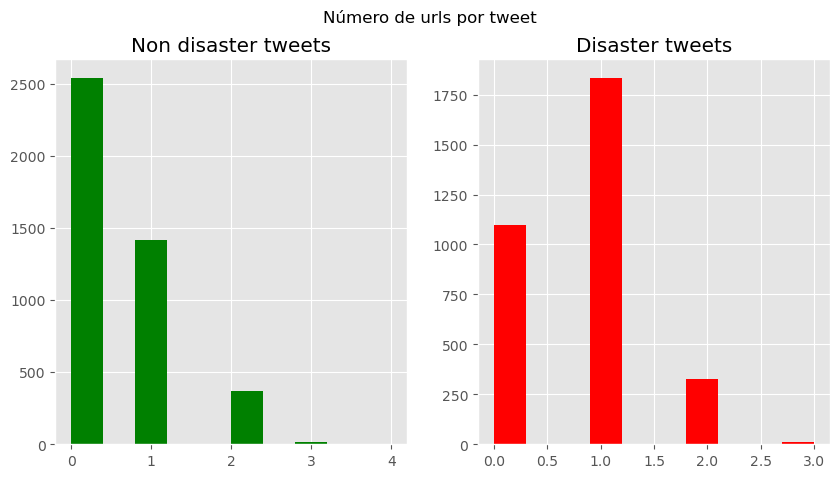

In [13]:
# Expresión regular para coincidir con URLs
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# FIGURA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de URLs por tweet
url_count_0 = X_train[X_train['target'] == 0]['text'].apply(lambda x: len(re.findall(url_regex, x)))
url_count_1 = X_train[X_train['target'] == 1]['text'].apply(lambda x: len(re.findall(url_regex, x)))

ax1.hist(url_count_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(url_count_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de urls por tweet')

plt.show()

### Número de signos de puntuación por Tweet

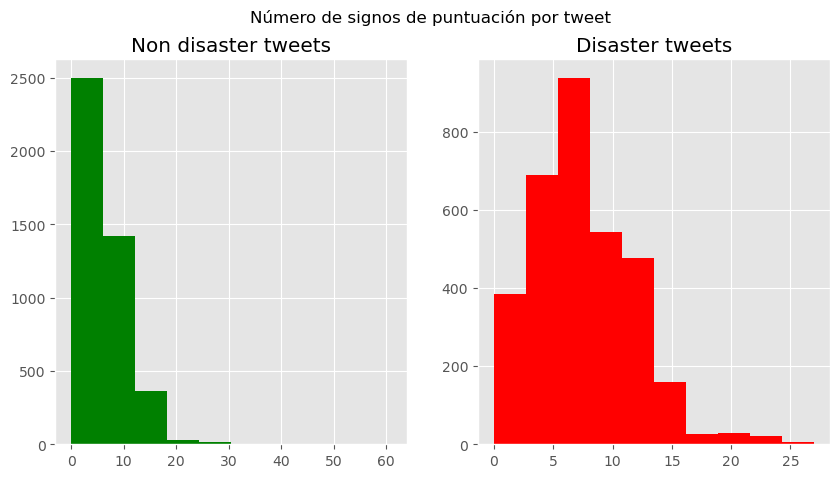

In [14]:
# Función para contar el número de signos de puntuación en un texto
def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

# Calculamos el número de signos de puntuación por tweet
punct_count_0 = X_train[X_train['target'] == 0]['text'].apply(count_punctuation)
punct_count_1 = X_train[X_train['target'] == 1]['text'].apply(count_punctuation)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(punct_count_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(punct_count_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de signos de puntuación por tweet')

plt.show()

### Número de hashtags(#) por Tweet

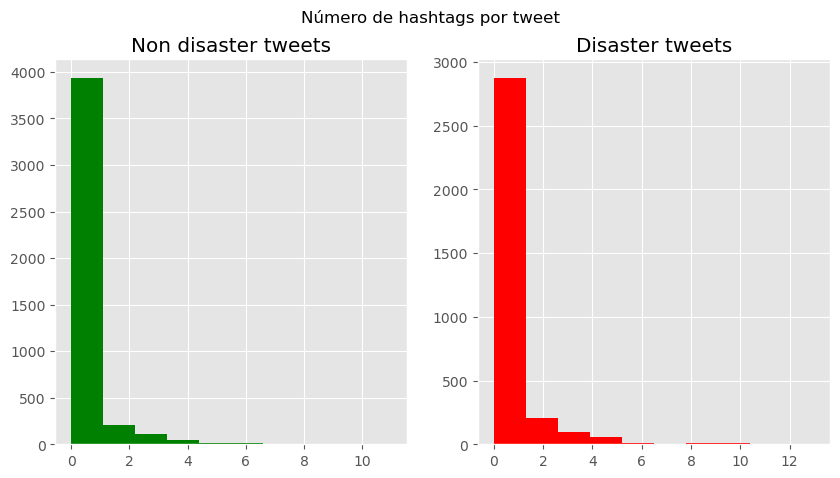

In [15]:
# Calculamos el número de hashtags por tweet
hashtag_count_0 = X_train[X_train['target'] == 0]['text'].str.count('#')
hashtag_count_1 = X_train[X_train['target'] == 1]['text'].str.count('#')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(hashtag_count_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(hashtag_count_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de hashtags por tweet')

plt.show()

### Número de @ por tweet

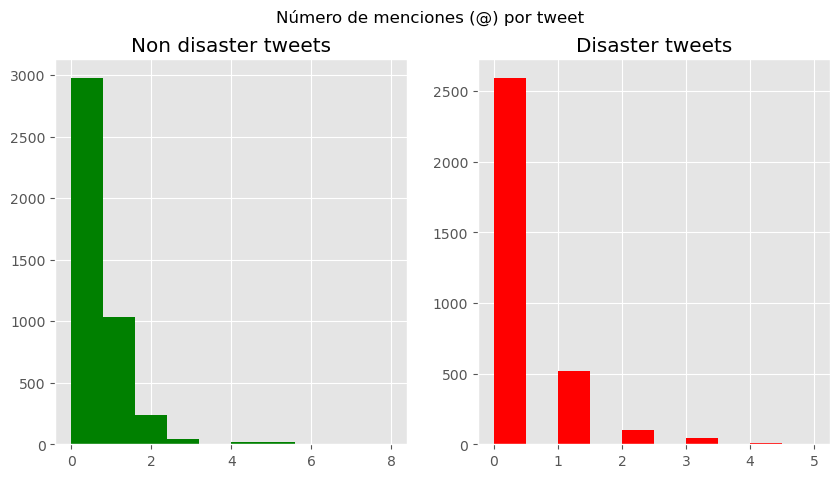

In [16]:
# Calculamos el número de menciones por tweet
mention_count_0 = X_train[X_train['target'] == 0]['text'].str.count('@')
mention_count_1 = X_train[X_train['target'] == 1]['text'].str.count('@')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(mention_count_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(mention_count_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de menciones (@) por tweet')

plt.show()

### Stopwords más utilizadas

Estas palabras no tienen un significado por si solas, sino que modifican o acompañan a otras, este grupo suele estar conformado por artículos, pronombres, preposiciones, adverbios e incluso algunos verbos.

En el procesamiento de datos en lenguaje natural son filtradas antes o después del proceso en si, no se consideran por su nulo significado, en el caso de los buscadores como Google no lo consideran al momento de posicionar, pero si al momento de mostrar los resultados de búsqueda.

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
def plot_stopwords(label):
    tweets_stopwords = {}
    for words in X_train[X_train['target'] == label]['text'].str.split():
        sw = list(set(words).intersection(stopwords.words('english')))
        for w in sw:
            if w in tweets_stopwords.keys():
                tweets_stopwords[w] += 1
            else:
                tweets_stopwords[w] = 1
                
    top = sorted(tweets_stopwords.items(), key=lambda x:x[1],reverse=True)[:10]
    plt.bar(*zip(*top))
    plt.show()

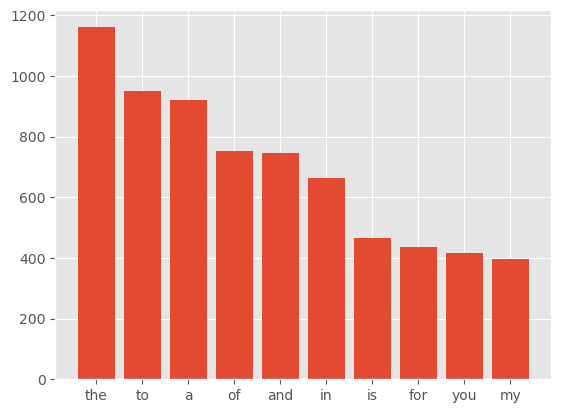

In [20]:
plot_stopwords(0)

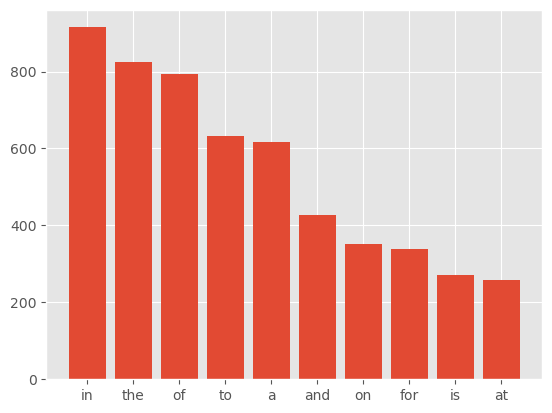

In [21]:
plot_stopwords(1)

### Análisis signos de puntuación

In [22]:
def plot_punctuation(label):
    tweets_stopwords = {}
    for words in X_train[X_train['target'] == label]['text'].str.split():
        sw = list(set(words).intersection(string.punctuation))
        for w in sw:
            if w in tweets_stopwords.keys():
                tweets_stopwords[w] += 1
            else:
                tweets_stopwords[w] = 1
                
    top = sorted(tweets_stopwords.items(), key=lambda x:x[1],reverse=True)[:20]
    plt.figure(figsize=(10, 5))
    plt.bar(*zip(*top))
    plt.show()

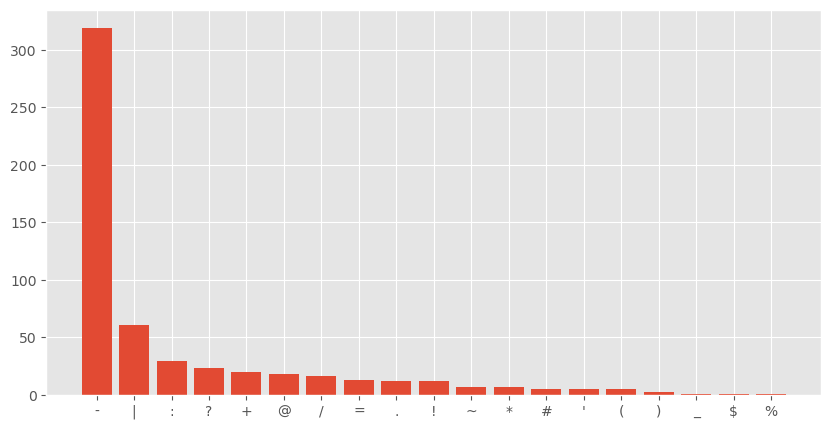

In [23]:
plot_punctuation(0)

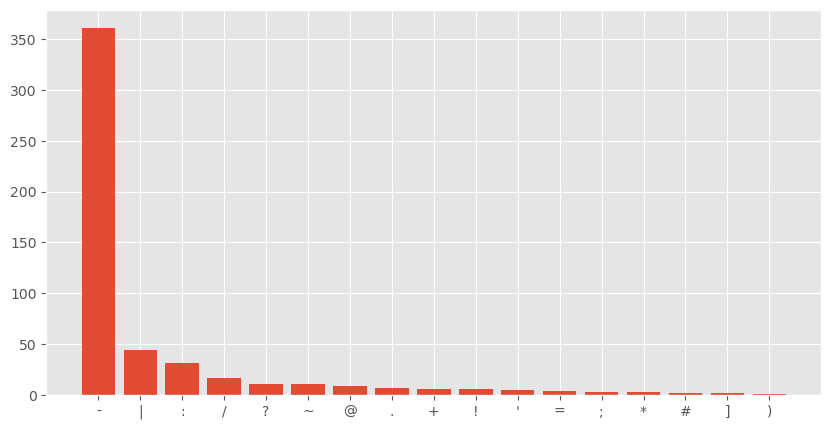

In [24]:
plot_punctuation(1)

### Etiquetado POS (Clasificar por Nº de Sustantivos, Adjetivos, Verbos...)

In [25]:
# Asegúrate de descargar los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\enric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\enric\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\enric\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
df = X_train.copy()

In [27]:
def pos_tagging(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    return tagged

def classify_pos(tagged):
    counts = Counter(tag for word, tag in tagged)
    return counts

In [28]:
# Etiquetado POS
df['pos_tagged'] = df['text'].apply(pos_tagging)

# Clasificación por Nº de Sustantivos, Adjetivos, Verbos
df['pos_counts'] = df['pos_tagged'].apply(classify_pos)

# Sumarización de datos para visualización
pos_counts_0 = df[df['target'] == 0]['pos_counts'].apply(pd.Series).fillna(0).sum()
pos_counts_1 = df[df['target'] == 1]['pos_counts'].apply(pd.Series).fillna(0).sum()

In [29]:
description = """
PRP$: Pronombre posesivo
NNS: Sustantivo plural
VBP: Verbo, no 3ª persona singular del presente
DT: Determinante
NNP: Nombre propio singular
IN: Preposición o conjunción subordinante
#: Signo de número
NN: Sustantivo, singular o masa
PRP: Pronombre personal
"""


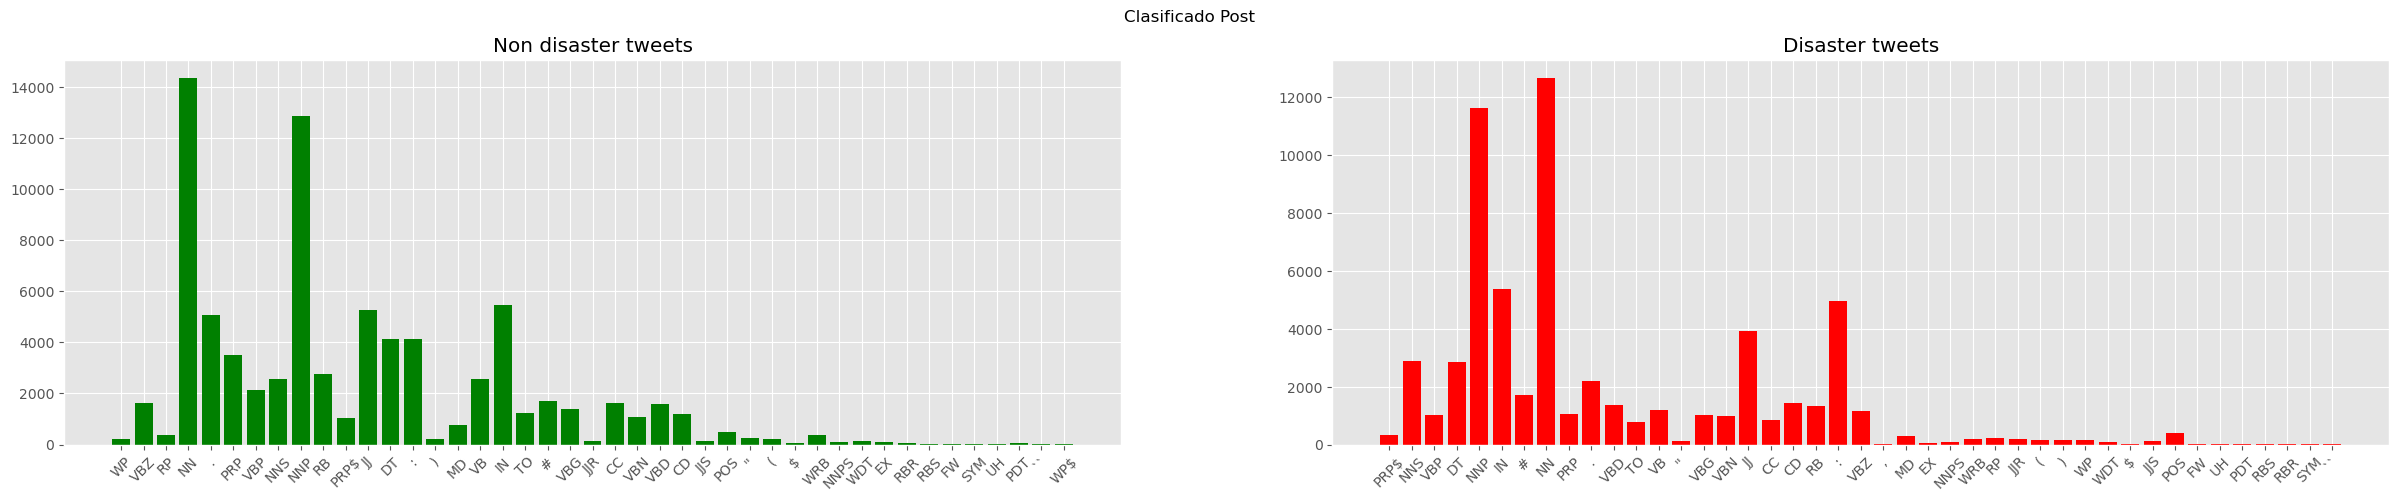

In [30]:
# Visualización de Etiquetado POS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5))

# Agregar la descripción como una caja de texto a la figura
#fig.text(1.05, 0.5, description, ha='left', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=1'))

ax1.bar(pos_counts_0.keys(), pos_counts_0, color='green')
ax1.set_title('Non disaster tweets')
ax1.set_xticks(range(len(pos_counts_0)))
ax1.set_xticklabels(pos_counts_0.keys(), rotation=45)

# Para el segundo histograma
ax2.bar(pos_counts_1.keys(), pos_counts_1, color='red')
ax2.set_title('Disaster tweets')
ax2.set_xticks(range(len(pos_counts_1)))
ax2.set_xticklabels(pos_counts_1.keys(), rotation=45)

fig.suptitle("Clasificado Post")
plt.show()


In [31]:
df_post = pd.concat([pos_counts_0, pos_counts_1], axis=1)
df_post.columns = ['pos_counts_0', 'pos_counts_1']

# 1. Diferencia
df_post['difference'] = df_post['pos_counts_1'] - df_post['pos_counts_0']

# 2. Diferencia porcentual
df_post['percentage_difference'] = (df_post['difference'] / df_post['pos_counts_0']) * 100

# 3. Estadísticas descriptivas
stats_0 = df_post['pos_counts_0'].describe()
stats_1 = df_post['pos_counts_1'].describe()

In [32]:
df_post

,pos_counts_0,pos_counts_1,difference,percentage_difference
WP,231.0,170.0,-61.0,-26.406926
VBZ,1639.0,1162.0,-477.0,-29.103112
RP,364.0,230.0,-134.0,-36.813187
NN,14368.0,12654.0,-1714.0,-11.929287
.,5079.0,2178.0,-2901.0,-57.117543
PRP,3519.0,1059.0,-2460.0,-69.906223
VBP,2129.0,1008.0,-1121.0,-52.653828
NNS,2549.0,2879.0,330.0,12.946253
NNP,12862.0,11596.0,-1266.0,-9.842948
RB,2754.0,1326.0,-1428.0,-51.851852


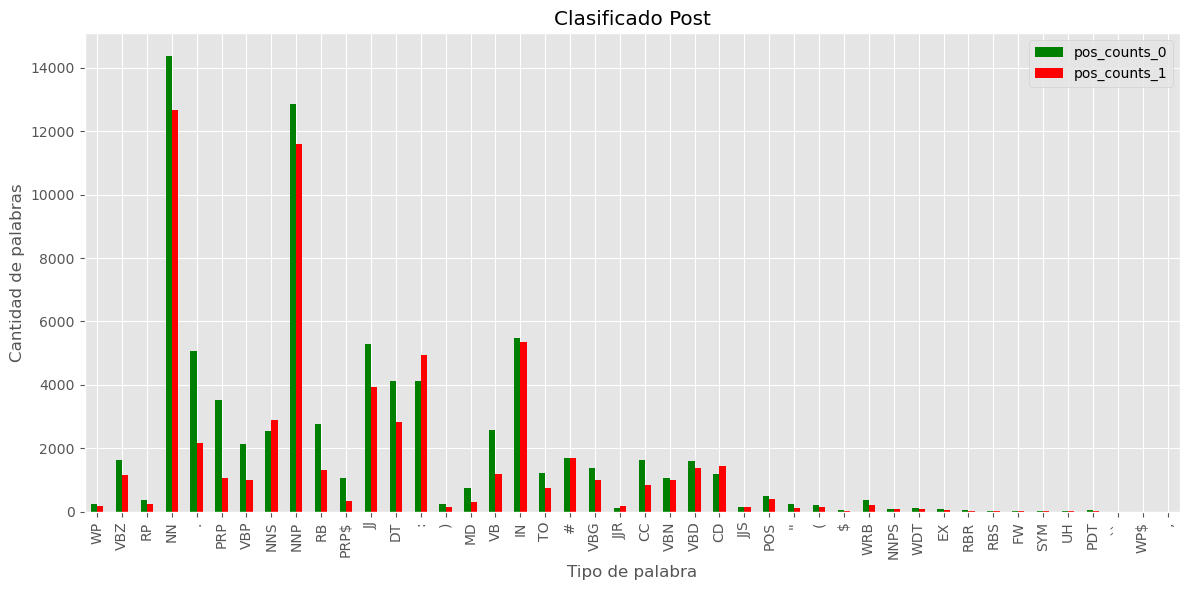

In [33]:
# Gráfico de barras para comparar visualmente
df_post[['pos_counts_0', 'pos_counts_1']].plot(kind='bar', figsize=(12,6), color=['green', 'red'])
plt.title('Clasificado Post')
plt.ylabel('Cantidad de palabras')
plt.xlabel('Tipo de palabra')
plt.tight_layout()
plt.show()

### Análisis Semántico y de Sentimientos

In [34]:
def sentiment_analysis(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

El SentimentIntensityAnalyzer devuelve un diccionario con cuatro valores después de evaluar un texto:
* **pos** - Proporción de positividad en el texto.
* **neu** - Proporción de neutralidad en el texto.
* **neg** - Proporción de negatividad en el texto.
* **compound** - Score compuesto que calcula el sentimiento del texto como un todo. Este valor es un número entre -1 (muy negativo) y 1 (muy positivo).

In [35]:
df_se = X_train.copy()

In [36]:
# Análisis Semántico y de Sentimientos
df_se['sentiment'] = df_se['text'].apply(sentiment_analysis)

# Sumarización de datos para visualización
sentiment_0 = df_se[df_se['target'] == 0]['sentiment'].apply(pd.Series).mean()
sentiment_1 = df_se[df_se['target'] == 1]['sentiment'].apply(pd.Series).mean()

df_se

,id,keyword,location,text,target,sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'comp..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"{'neg': 0.095, 'neu': 0.905, 'pos': 0.0, 'comp..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,"{'neg': 0.262, 'neu': 0.738, 'pos': 0.0, 'comp..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,"{'neg': 0.166, 'neu': 0.834, 'pos': 0.0, 'comp..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,"{'neg': 0.345, 'neu': 0.655, 'pos': 0.0, 'comp..."


In [37]:
df_se2 = pd.concat([sentiment_0, sentiment_1], axis=1)
df_se2

,0,1
neg,0.132318,0.173582
neu,0.765615,0.777081
pos,0.102070,0.049339
compound,-0.060607,-0.264571


In [38]:
df_se = pd.concat([sentiment_0, sentiment_1], axis=1)
df_se.columns = ['sentiment_0', 'sentiment_1']

# 1. Diferencia
df_se['difference'] = df_se['sentiment_1'] - df_se['sentiment_0']

# 2. Diferencia porcentual
df_se['percentage_difference'] = (df_se['difference'] / df_se['sentiment_0']) * 100

# 3. Estadísticas descriptivas
stats_0 = df_se['sentiment_0'].describe()
stats_1 = df_se['sentiment_1'].describe()

df_se

,sentiment_0,sentiment_1,difference,percentage_difference
neg,0.132318,0.173582,0.041264,31.185258
neu,0.765615,0.777081,0.011466,1.497672
pos,0.102070,0.049339,-0.052730,-51.661054
compound,-0.060607,-0.264571,-0.203964,336.534566


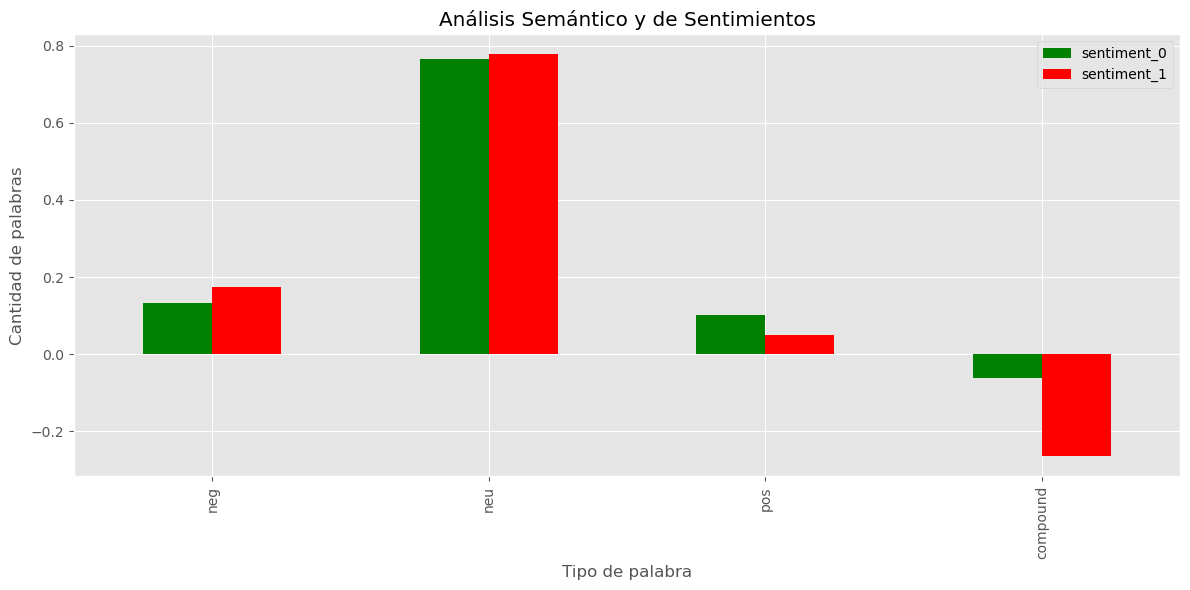

In [39]:
# Gráfico de barras para comparar visualmente
df_se[['sentiment_0', 'sentiment_1']].plot(kind='bar', figsize=(12,6), color=['green', 'red'])
plt.title('Análisis Semántico y de Sentimientos')
plt.ylabel('Cantidad de palabras')
plt.xlabel('Tipo de palabra')
plt.tight_layout()
plt.show()

### Análisis de Ngramas

#### N = 2

In [40]:
cv = CountVectorizer(ngram_range=(2, 2))
sum_words = cv.fit_transform(X_train['text']).sum(axis=0)

# Calculamos 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

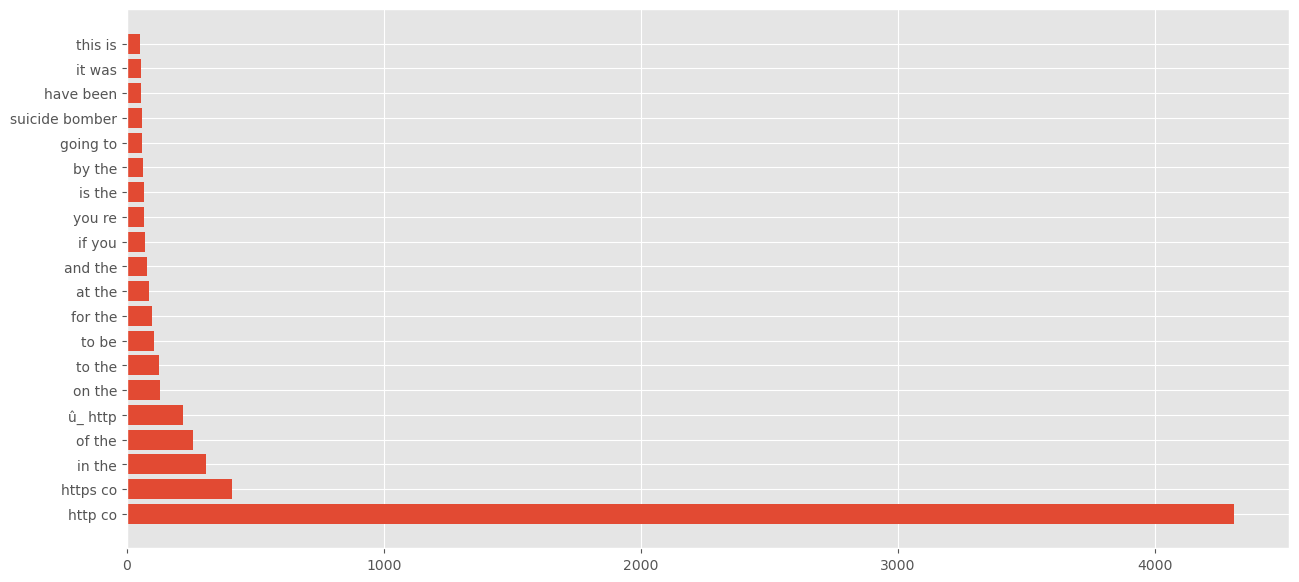

In [41]:
plt.figure(figsize=(15, 7))
plt.barh(*zip(*words_freq))
plt.show()

#### No se puede obtener información relevante
Se observa la presencia de Ngramas que carecen de sentido, por ejemplo: "https co", "https co", entre otros. Esto se debe a que existen elementos en el texto que son irrelevantes para la solución del problema, como las URLs. Además, es aconsejable eliminar las 'stopwords', ya que estas aparecen repetidamente en ambos tipos de tweets y no proporcionan información significativa. También sería apropiado eliminar emojis y signos de puntuación, ya que son irrelevantes para el análisis.
**Nota**: Es esencial tener en cuenta todas estas modificaciones durante la fase de creación del modelo. 

Para abordar estos problemas, es necesario filtrar adecuadamente el texto.

### Filtrado del texto

<span style="color:red"> No se por que no se aplican bien las transformaciones mediante </span>
* from package_utilities import clean_text_field
* clean_text_field(df)

<span style="color:red"> Y me toca aplicarlas manualmente en la sección de abajo.</span>

In [42]:
from package_utilities import remove_url, remove_emoji, remove_punctuation, remove_stopwords, remove_html

X_train_filtered = df.copy()

X_train_filtered['text'] = X_train_filtered['text'].apply(remove_url)
X_train_filtered['text'] = X_train_filtered['text'].apply(remove_html)
X_train_filtered['text'] = X_train_filtered['text'].apply(remove_emoji)
X_train_filtered['text'] = X_train_filtered['text'].apply(remove_punctuation)
X_train_filtered['text'] = X_train_filtered['text'].apply(remove_stopwords)

X_train_filtered

,id,keyword,location,text,target,pos_tagged,pos_counts
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,"[(Our, PRP$), (Deeds, NNS), (are, VBP), (the, ...","{'PRP$': 1, 'NNS': 1, 'VBP': 1, 'DT': 3, 'NNP'..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[(Forest, NNP), (fire, NN), (near, IN), (La, N...","{'NNP': 5, 'NN': 1, 'IN': 1, '.': 1}"
2,5,NaN,NaN,residents asked shelter place notified officer...,1,"[(All, DT), (residents, NNS), (asked, VBD), (t...","{'DT': 2, 'NNS': 3, 'VBD': 1, 'TO': 1, 'VB': 1..."
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,"[(13,000, CD), (people, NNS), (receive, JJ), (...","{'CD': 1, 'NNS': 3, 'JJ': 1, '#': 1, 'VBP': 1,..."
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,"[(Just, RB), (got, VBN), (sent, VBD), (this, D...","{'RB': 1, 'VBN': 1, 'VBD': 1, 'DT': 2, 'NN': 3..."
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearb...,1,"[(Two, CD), (giant, JJ), (cranes, NNS), (holdi...","{'CD': 1, 'JJ': 2, 'NNS': 2, 'VBG': 1, 'DT': 1..."
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fires cali...,1,"[(@, JJ), (aria_ahrary, JJ), (@, NN), (TheTawn...","{'JJ': 4, 'NN': 5, 'NNP': 3, 'DT': 3, 'IN': 4,..."
7610,10871,NaN,NaN,m194 0104 utc5km volcano hawaii,1,"[(M1.94, NNP), ([, VBD), (01:04, CD), (UTC, NN...","{'NNP': 6, 'VBD': 1, 'CD': 2, '.': 2, 'IN': 1,..."
7611,10872,NaN,NaN,police investigating ebike collided car little...,1,"[(Police, NNP), (investigating, NN), (after, I...","{'NNP': 3, 'NN': 5, 'IN': 3, 'DT': 2, 'JJ': 4,..."


In [43]:
X_no_disaster_filtered = X_train_no_disaster.copy()

X_no_disaster_filtered['text'] = X_no_disaster_filtered['text'].apply(remove_url)
X_no_disaster_filtered['text'] = X_no_disaster_filtered['text'].apply(remove_html)
X_no_disaster_filtered['text'] = X_no_disaster_filtered['text'].apply(remove_emoji)
X_no_disaster_filtered['text'] = X_no_disaster_filtered['text'].apply(remove_punctuation)
X_no_disaster_filtered['text'] = X_no_disaster_filtered['text'].apply(remove_stopwords)

X_disaster_filtered = X_train_disaster.copy()

X_disaster_filtered['text'] = X_disaster_filtered['text'].apply(remove_url)
X_disaster_filtered['text'] = X_disaster_filtered['text'].apply(remove_html)
X_disaster_filtered['text'] = X_disaster_filtered['text'].apply(remove_emoji)
X_disaster_filtered['text'] = X_disaster_filtered['text'].apply(remove_punctuation)
X_disaster_filtered['text'] = X_disaster_filtered['text'].apply(remove_stopwords)

### NGramas Filtrados

#### N = 2

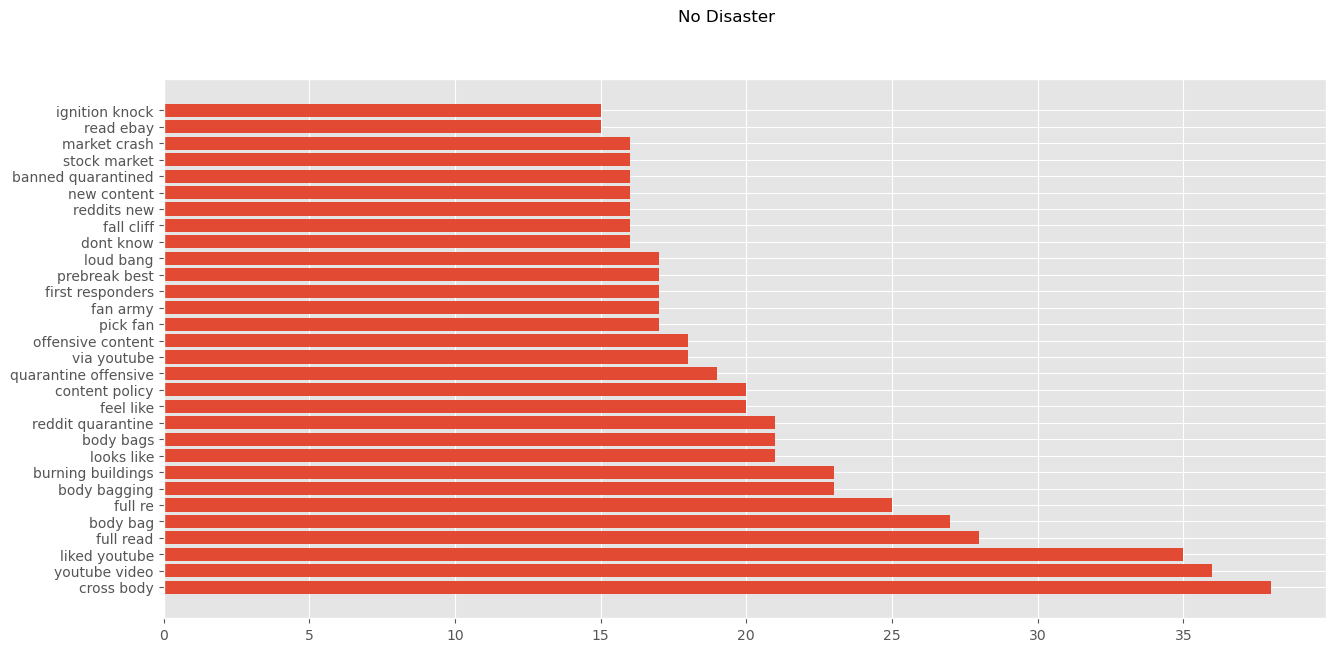

In [44]:
cv = CountVectorizer(ngram_range=(2, 2))
sum_words = cv.fit_transform(X_no_disaster_filtered['text']).sum(axis=0)

# Calculamos 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:30]

# Representación
plt.figure(figsize=(15, 7))
plt.barh(*zip(*words_freq))
plt.suptitle("No Disaster")
plt.show()

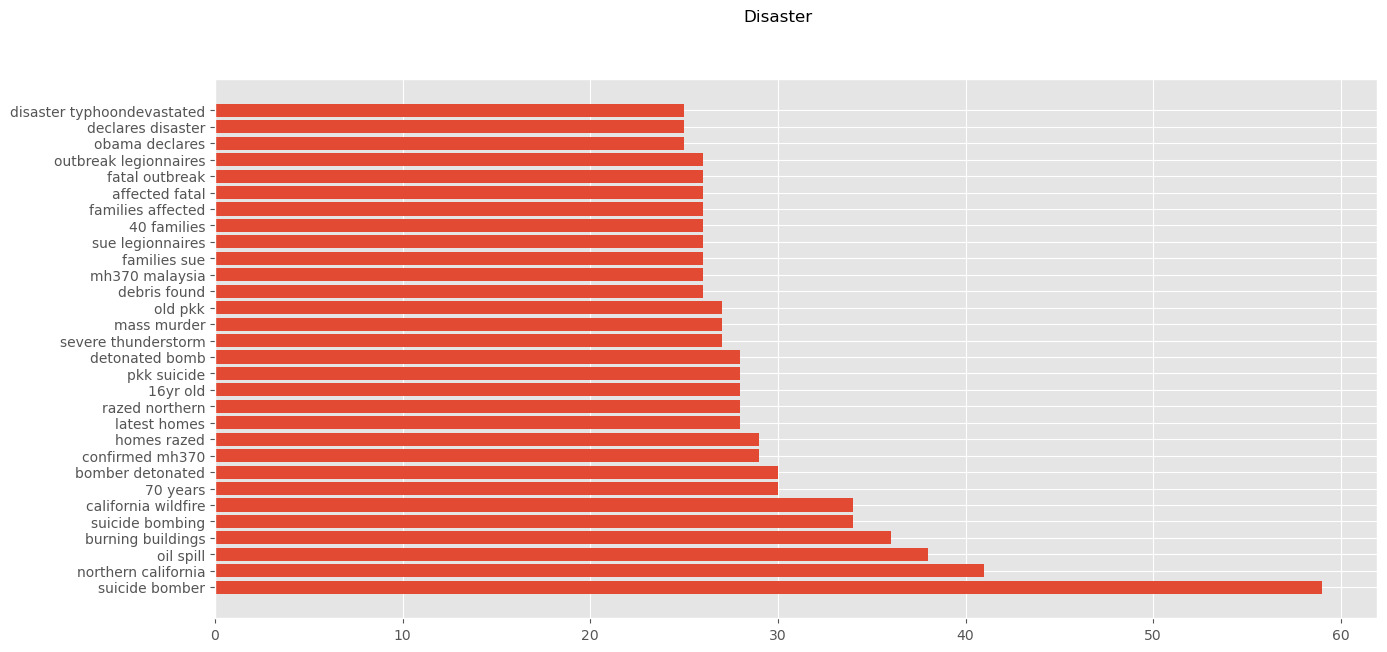

In [45]:
cv = CountVectorizer(ngram_range=(2, 2))
sum_words = cv.fit_transform(X_disaster_filtered['text']).sum(axis=0)

# Calculamos 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:30]

# Representación
plt.figure(figsize=(15, 7))
plt.barh(*zip(*words_freq))
plt.suptitle("Disaster")
plt.show()

#### N = 3

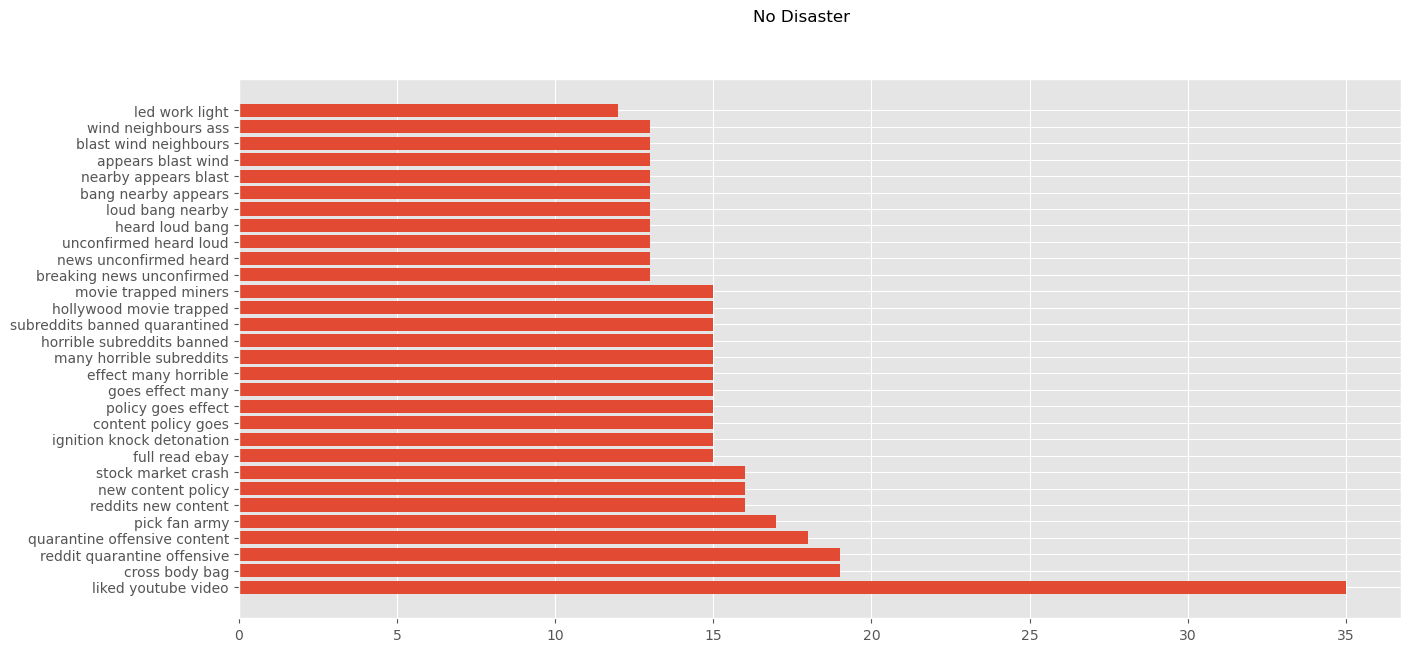

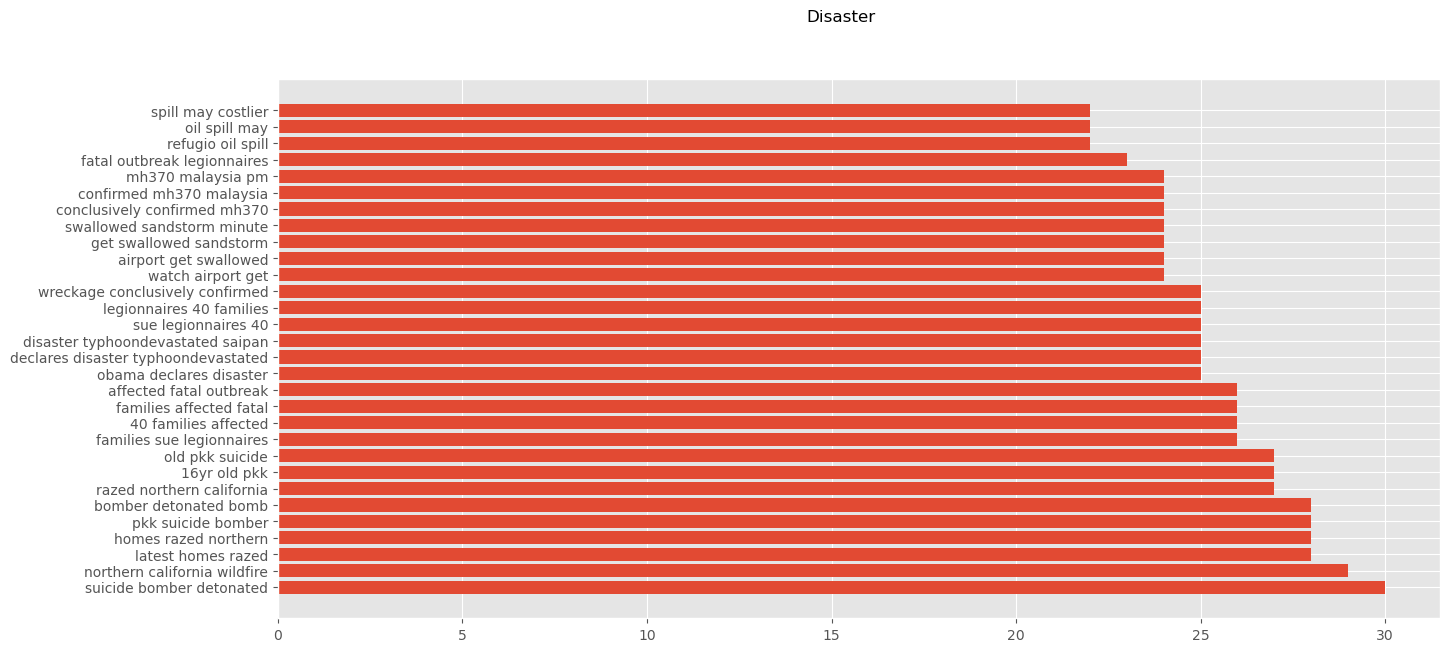

In [46]:
cv = CountVectorizer(ngram_range=(3, 3))
sum_words = cv.fit_transform(X_no_disaster_filtered['text']).sum(axis=0)

# Calculamos 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:30]

# Representación
plt.figure(figsize=(15, 7))
plt.barh(*zip(*words_freq))
plt.suptitle("No Disaster")
plt.show()

cv = CountVectorizer(ngram_range=(3, 3))
sum_words = cv.fit_transform(X_disaster_filtered['text']).sum(axis=0)

# Calculamos 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:30]

# Representación
plt.figure(figsize=(15, 7))
plt.barh(*zip(*words_freq))
plt.suptitle("Disaster")
plt.show()

# 4 Informe EDA

## Introducción
Este informe tiene la finalidad de determinar qué transformaciones son las más influyentes para obtener el mejor resultado en la creación de un modelo clasificador de tweets que distinga entre aquellos que hablan de desastres naturales y aquellos que no.
* Es relevante mencionar que este proceso es más necesario en "2-Machine_Learning" que en "3-Deep_Learning". Sin embargo, siempre es útil probar ambos para comparar resultados y potencialmente reducir el tiempo de compilación.

## Informe

### Adiciones
Ninguna característica analizada ha mostrado una varianza significativa como para crear elementos nuevos en el dataset. Las opciones exploradas incluyen:
* Número de palabras por tweet
* Número de palabras únicas por tweet
* Longitud media de las palabras por tweet
* Número de caracteres por tweet
* Número de URLs por tweet
* Número de signos de puntuación por tweet
* Número de hashtags por tweet
* Número de menciones "@" por tweet
* Etiquetado POS (clasificar por número de sustantivos, adjetivos, verbos, etc.)
* Análisis semántico y de sentimientos

### Filtrado
Los elementos que conviene eliminar para reducir la dimensionalidad del dataset son:
* **Stopwords** (los utilizados son prácticamente los mismos en cada caso)
* **Signos de puntuación** (presentes en cantidades similares)
* **URLs** (presentes en cantidades similares y no aportan información valiosa)
* **Emojis** (no aportan información valiosa)

### A vigilar
En los NGramas con \(N=2\), hay ciertos ngramas que aparecen tanto en tweets sobre catástrofes como en otros que no. Sin embargo, debido a que son pocos y, excepto dos, no muestran una varianza muy grande, se considera que no es necesario eliminarlos. Aún así, se podría intentar si se busca perfeccionar el modelo, pero es importante considerar dos factores:
* Necesidad de un preprocesado adicional para futuras clasificaciones en el modelo.
* Posibilidad (aunque baja) de overfitting en relación con los datos reales.

## Opcines descartadas por el miedo al overfittin
* **Frecuencia de Palabras Clave**: Considerar las palabras más frecuentes en tweets de desastres naturales y contrastarlas con las palabras frecuentes en otros tweets. Esta comparación podría proporcionar información sobre palabras clave que podrían ser usadas como características para la clasificación.

* **TF-IDF (Term Frequency-Inverse Document Frequency)**: En lugar de simplemente contar las ocurrencias de las palabras, puedes transformar el texto utilizando TF-IDF. Esta métrica reflejará la importancia de una palabra para un documento en una colección de documentos, lo que puede ser útil para diferenciar palabras que son realmente relevantes en el contexto de desastres naturales de aquellas que son comunes en todos los tweets.

* **Análisis de la Estructura del Tweet**: Podrías investigar si la estructura de los tweets (por ejemplo, si comienzan con un verbo o si contienen una secuencia específica de tipos de palabras) varía entre las dos clases.

